--- 
title: Change of Slope (or Broken-Stick Regression) Model
---

We will illustrate the use of the model 
\begin{equation*}
y_t = \beta_0 + \beta_1 t + \beta_2 ReLU(t - c) + \epsilon_t
\end{equation*}
as well as 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 ReLU(t - c_1) + \beta_3 ReLU(t - c_2) + \epsilon_t
\end{equation*}
on the CA population dataset.

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## California Population Dataset

Consider the following dataset (downloaded from FRED) on annual estimates of the resident population of California from 1900 to present. 

  observation_date   CAPOP
0       1900-01-01  1490.0
1       1901-01-01  1550.0
2       1902-01-01  1623.0
3       1903-01-01  1702.0
4       1904-01-01  1792.0
5       1905-01-01  1893.0
6       1906-01-01  1976.0
7       1907-01-01  2054.0
8       1908-01-01  2161.0
9       1909-01-01  2282.0
    observation_date      CAPOP
115       2015-01-01  38904.296
116       2016-01-01  39149.186
117       2017-01-01  39337.785
118       2018-01-01  39437.463
119       2019-01-01  39437.610
120       2020-01-01  39521.958
121       2021-01-01  39142.565
122       2022-01-01  39142.414
123       2023-01-01  39198.693
124       2024-01-01  39431.263


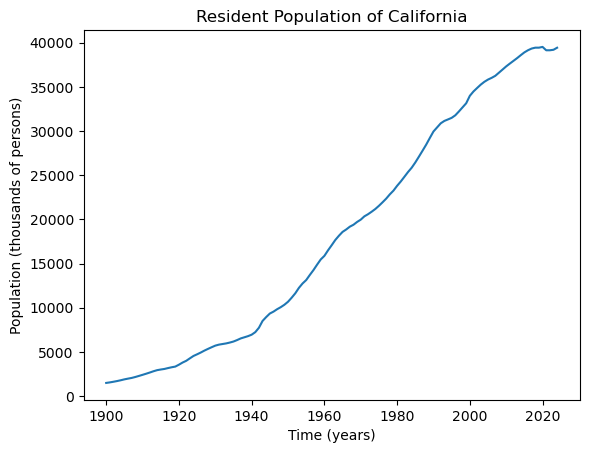

In [156]:
capop = pd.read_csv('CAPOP-Feb2025FRED.csv')
print(capop.head(10))
print(capop.tail(10))
tme = np.arange(1900, 2025)
plt.plot(tme, capop['CAPOP'])
plt.xlabel("Time (years)")
plt.ylabel('Population (thousands of persons)')
plt.title("Resident Population of California")
plt.show()

We fit some basic regression  models to this data. We shall work with the logarithms of the population data, as this will lead to models with better interpretability. 

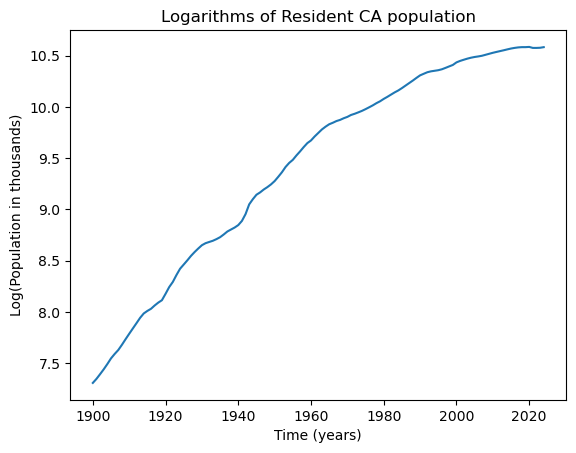

In [157]:
y = np.log(capop['CAPOP'])
n = len(y)
plt.plot(tme, y)
plt.xlabel("Time (years)")
plt.ylabel('Log(Population in thousands)')
plt.title("Logarithms of Resident CA population")
plt.show()

Let us start by fitting a simple linear regression model to this dataset.

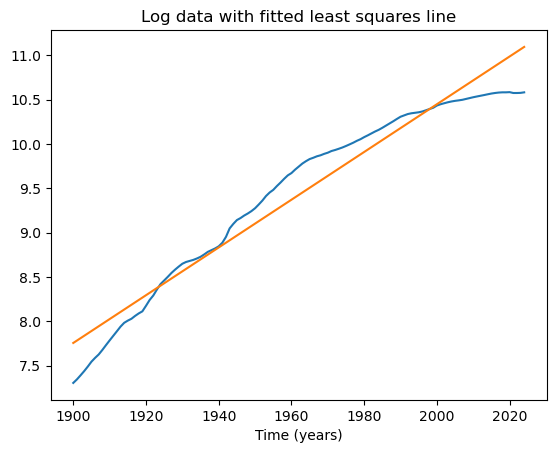

                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2343.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           6.13e-82
Time:                        23:02:46   Log-Likelihood:                 10.482
No. Observations:                 125   AIC:                            -16.96
Df Residuals:                     123   BIC:                            -11.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7301      0.040    191.493      0.0

In [158]:
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x])
md = sm.OLS(y, X).fit()
plt.plot(tme, y)
plt.plot(tme, md.fittedvalues)
plt.xlabel('Time (years)')
plt.title('Log data with fitted least squares line')
plt.show()
print(md.summary())

The fitted slope coefficient here is 0.0269. The interpretation is that the population increases by 2.69\% each year (why?).

From the plot, it is clear that the population growth rate is clearly not 2.69\% uniformly. In the initial years, the growth rate seems to be higher than 2.69\%, and in recent years, it seems to be lower. The simple linear regression model cannot pick up these variable growth rates. We can instead consider the following nonlinear regression model: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 t + \beta_2 (t - c)_+ + \epsilon_t 
\end{equation*}
The key quantity for inference is the RSS defined as follows. 

In [159]:
def rss(c):
    x = np.arange(1, n+1)
    xc = ((x > c).astype(float))*(x - c)
    X = np.column_stack([np.ones(n), x, xc])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

We compute $RSS(c)$ for each $c \in \{1, \dots, n\}$ as follows.  

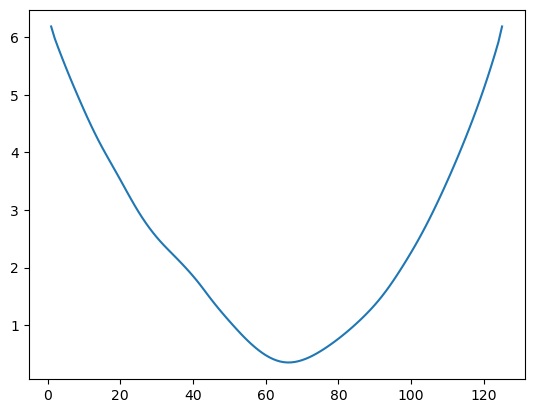

In [160]:
allcvals = np.arange(1, n+1) 
rssvals = np.array([rss(c) for c in allcvals])
plt.plot(allcvals, rssvals)
plt.show()

The estimate $\hat{c}$ is obtained by minimizing $RSS(c)$ as follows. 

In [162]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)
print(tme[c_hat - 1])

66
1965


Point estimates of the other parameters are obtained as follows. 

In [163]:
#Estimates of other parameters: 
x = np.arange(1, n+1)
c = c_hat
xc = ((x > c).astype(float))*(x-c)
X = np.column_stack([np.ones(n), x, xc])
md = sm.OLS(y, X).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 
rss_chat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_chat/n)
sigma_unbiased = np.sqrt((rss_chat)/(n-3))
print(np.array([sigma_mle, sigma_unbiased])) #sig is the true value of sigma which generated the data

const    7.367739
x1       0.038069
x2      -0.024040
dtype: float64
[0.05287982 0.05352604]


The estimate of $\hat{\beta}_1$ is 0.038 and the estimate of $\hat{\beta}_2$ is $-0.024$. This means that the growth rate before 1965 was 3.8\% while the growth rate after 1965 is $3.8 - 2.4 = 1.4$\%. 

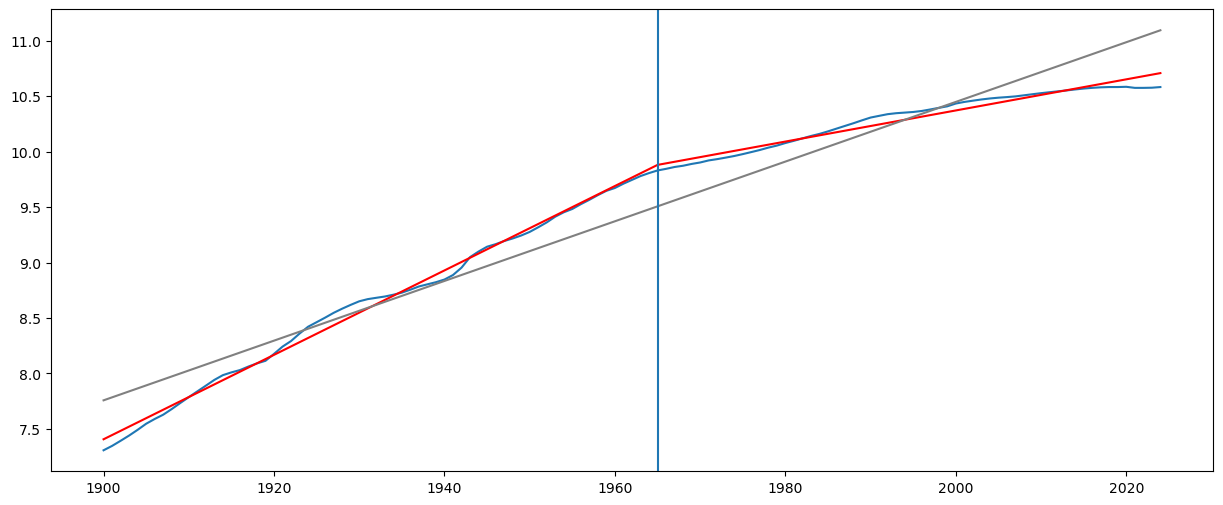

1965


In [164]:
#Plot fitted values
X_linmod = np.column_stack([np.ones(n), x])
linmod = sm.OLS(y, X_linmod).fit()
plt.figure(figsize = (15, 6))
#Plot this broken regression fitted values along with linear model fitted values 
plt.plot(tme, y)
plt.plot(tme, md.fittedvalues, color = 'red')
plt.plot(tme, linmod.fittedvalues, color = 'gray')
plt.axvline(tme[c_hat-1])
plt.show()
print(tme[c_hat-1])

The interpretation is that the growth rate before 1965 is 3.8\% while the growth rate after 1965 is 3.8 - 2.4 = 1.4\%. 

For uncertainty quantification, we can do Bayesian analysis. The posterior density is computed as follows. 

In [165]:
#Bayesian log posterior
def logpost(c):
    x = np.arange(1, n+1)
    xc = ((x > c).astype(float))*(x - c)
    X = np.column_stack([np.ones(n), x, xc])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]


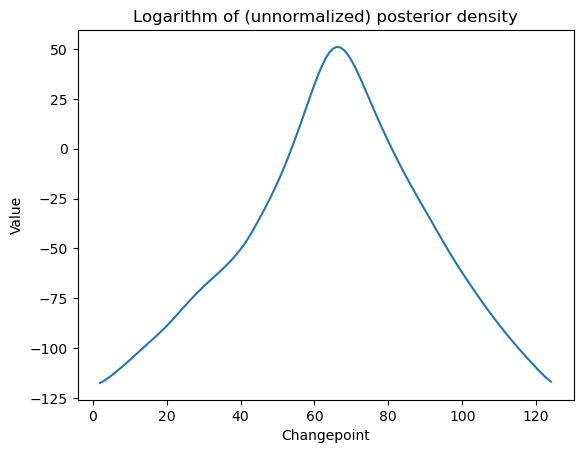

In [166]:
allcvals = np.arange(2, n) #we are omitting c = 1 and c = n to prevent singularity
print(allcvals)
logpostvals = np.array([logpost(c) for c in allcvals])
plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
#this plot looks similar to the RSS plot

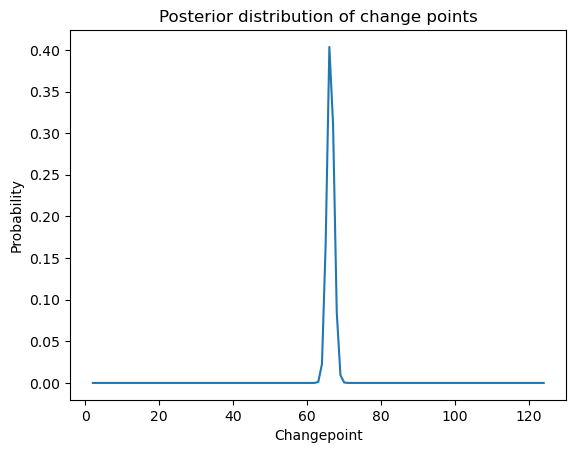

In [167]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))
plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

In [168]:
#95% credible interval for c:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
c_est = allcvals[est_ind]
#95% credible interval for f:
ci_c_low = allcvals[est_ind - m]
ci_c_high = allcvals[est_ind + m]
print(np.array([c_est, ci_c_low, ci_c_high]))
print(np.array([tme[c_est-1], tme[ci_c_low-1], tme[ci_c_high-1]]))

[66 63 69]
[1965 1962 1968]


We now draw posterior samples. First let us draw posterior samples from $c$. 

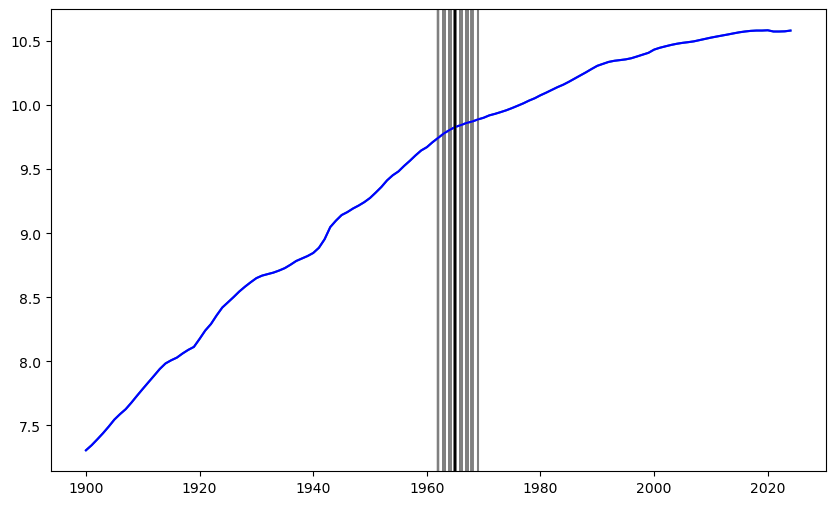

In [169]:
#Drawing posterior samples for c: 
N = 4000
rng = np.random.default_rng(seed = 42)
cpostsamples = rng.choice(allcvals, N, replace = True, p = postvals)

#Let us plot the posterior samples for c on the original data:
plt.figure(figsize = (10, 6))
plt.plot(tme, y)
for i in range(N):
    plt.axvline(x = tme[cpostsamples[i]-1], color = 'gray')
plt.plot(tme, y, color = 'blue')
plt.axvline(x = tme[c_hat-1], color = 'black')
plt.show()

Next we obtain posterior samples from all the parameters. 

In [170]:
#Drawing posterior samples from all the parameters: c, b0, b1, b2, sigma
post_samples = np.zeros(shape = (N, 5))
post_samples[:,0] = cpostsamples
for i in range(N):
    c = cpostsamples[i]
    x = np.arange(1, n+1)
    xc = ((x > c).astype(float))*(x-c)
    X = np.column_stack([np.ones(n), x, xc])
    p = X.shape[1]
    md_c = sm.OLS(y, X).fit()
    chirv = rng.chisquare(df = n-p)
    sig_sample = np.sqrt(np.sum(md_c.resid ** 2)/chirv) #posterior sample from sigma
    post_samples[i, (p+1)] = sig_sample
    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_c.params, cov = covmat, size = 1)
    post_samples[i, 1:(p+1)] = beta_sample
print(post_samples)

[[ 6.70000000e+01  7.35543206e+00  3.78284185e-02 -2.35296311e-02
   5.75934218e-02]
 [ 6.60000000e+01  7.37109229e+00  3.80011393e-02 -2.41028088e-02
   5.85663572e-02]
 [ 6.70000000e+01  7.36961261e+00  3.78568470e-02 -2.43582244e-02
   5.30338688e-02]
 ...
 [ 6.60000000e+01  7.37235895e+00  3.81403758e-02 -2.43364458e-02
   5.82914757e-02]
 [ 6.60000000e+01  7.37353325e+00  3.80375482e-02 -2.38608929e-02
   5.32935240e-02]
 [ 6.50000000e+01  7.35145275e+00  3.85611639e-02 -2.42527075e-02
   5.24710852e-02]]


In [171]:
#Summary of the posterior samples:
post_samples[:,0] = tme[cpostsamples-1]
pd.DataFrame(post_samples).describe(percentiles=[.025, 0.25, 0.5, 0.75, .975])

,0,1,2,3,4
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1965.290500,7.369251,0.038001,-0.024073,0.054025
std,0.970229,0.014072,0.000379,0.000538,0.003486
min,1962.000000,7.302470,0.036578,-0.025747,0.044324
2.5%,1964.000000,7.341798,0.037263,-0.025113,0.047755
25%,1965.000000,7.359820,0.037750,-0.024432,0.051569
50%,1965.000000,7.369273,0.038000,-0.024079,0.053897
75%,1966.000000,7.378579,0.038261,-0.023715,0.056224
97.5%,1967.000000,7.396714,0.038728,-0.023010,0.061207
max,1969.000000,7.418791,0.039597,-0.021922,0.068179


The above table can be used to obtain 95\% credible intervals for the parameters. For example, the 2.5th percentile for $\sigma$ is 0.047755, and the 97.5th percentile for $\sigma$ is 0.061207. So our approximate 95\% credible interval for $\sigma$ is $[0.047755, 0.061207]$.

Posterior samples for the slope before c ($\beta_1$) and the slope after c ($\beta_1 + \beta_2$) are obtained as follows. 

In [172]:
post_samples_beforeslope = post_samples[:,2]
post_samples_afterslope = post_samples[:,2] + post_samples[:,3]
slopes = pd.DataFrame({'before': post_samples_beforeslope, 'after': post_samples_afterslope})
slopes.describe(percentiles = [0.025, 0.25, 0.5, 0.75, 0.975])

,before,after
count,4000.000000,4000.000000
mean,0.038001,0.013928
std,0.000379,0.000446
min,0.036578,0.012395
2.5%,0.037263,0.013037
25%,0.037750,0.013629
50%,0.038000,0.013933
75%,0.038261,0.014229
97.5%,0.038728,0.014795
max,0.039597,0.015607


From the above, 95\% credible interval for the growth rate before changepoint is $[3.7263 \%, 3.8728 \%]$ and for the growth rate after changepoint is $[1.3037 \%, 1.4795\%]$.

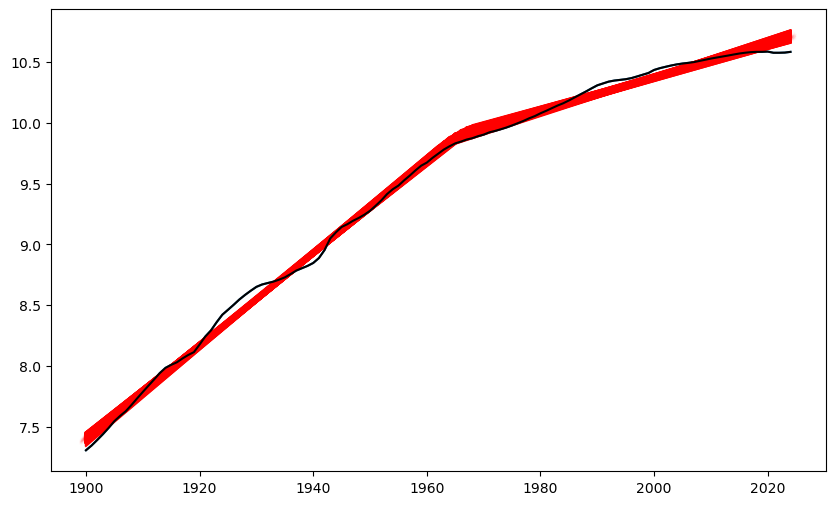

In [76]:
#PLotting the fitted values for the different posterior draws:
x = np.arange(1, n+1)
plt.figure(figsize = (10, 6))
plt.plot(tme, y)
for i in range(N):
    c = cpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]
    b2 = post_samples[i, 3]
    ftdval = b0 + b1 * x + b2 * ((x > c).astype(float))*(x-c)
    plt.plot(tme, ftdval, color = 'red')
plt.plot(tme, y, color = 'black')
plt.show()

Next let us consider the model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 ReLU(t - c_1) + \beta_3 ReLU(t - c_2) + \epsilon_t
\end{equation*}
Here $c = (c_1, c_2)$ and $RSS(c)$ is calculated as follows. 

In [173]:
def rss(c):
    n = len(y)
    x = np.arange(1, n+1)
    X = np.column_stack([np.ones(n), x])
    if np.isscalar(c):
        c = [c]
    for j in range(len(c)):
        xc = ((x > c[j]).astype(float))*(x-c[j])
        X = np.column_stack([X, xc])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans

Minimization of $RSS(c)$ is done as follows. 

In [175]:
c1_gr = np.arange(1, n-1)
c2_gr = np.arange(1, n-1)
X, Y = np.meshgrid(c1_gr, c2_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y']]), axis = 1)

In [176]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = min_row[:-1]
print(c_opt)

x       62.000000
y      101.000000
rss      0.199001
Name: 12361, dtype: float64
x     62.0
y    101.0
Name: 12361, dtype: float64


In [177]:
print(np.array([tme[100], tme[61]]))

[2000 1961]


The two change-of-slope points are identified at 1961 and 2000. The fitted regression line is plotted as follows (along with the fitted line for the single change-of-slope line for comparison). 

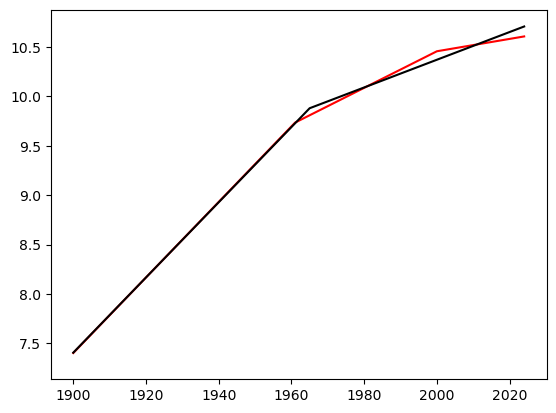

In [179]:
c = np.array(c_opt)
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x])
if np.isscalar(c):
    c = np.array([c])
for j in range(len(c)):
    xc = ((x > c[j]).astype(float))*(x-c[j])
    X = np.column_stack([X, xc])
md_c2 = sm.OLS(y, X).fit()
plt.plot(tme, y, color = 'None')
#plt.plot(tme, y, color = 'blue')
plt.plot(tme, md_c2.fittedvalues, color = 'red')
plt.plot(tme, md.fittedvalues, color = 'black')
plt.show()


Code for evaluating the RSS for three change-of-slope points $c_1, c_2, c_3$ is given below (this took 14 minutes to run on my computer).

In [141]:
c1_gr = np.arange(1, n-1)
c2_gr = np.arange(1, n-1)
c3_gr = np.arange(1, n-1)
X, Y, Z = np.meshgrid(c1_gr, c2_gr, c3_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten(), 'z': Z.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y'], row['z']]), axis = 1)

In [181]:
#The estimates of c_1, c_2, c_3 I obtained are given below (1924, 1964 and 2000)

#min_row = g.loc[g['rss'].idxmin()]
#print(min_row)
#c_opt = np.array(min_row[:-1])
c_opt = [101, 65, 25]
print(c_opt) #c_opt is 101, 65, 25
print(rss(c_opt))
print(np.array([tme[100], tme[64], tme[24]]))
#print(rss([62, 101]))
#print(rss(65))

[101, 65, 25]
0.10078403035063335
[2000 1964 1924]


The fitted regression line is given below. It is quite close to the line with two change-of-slope points. 

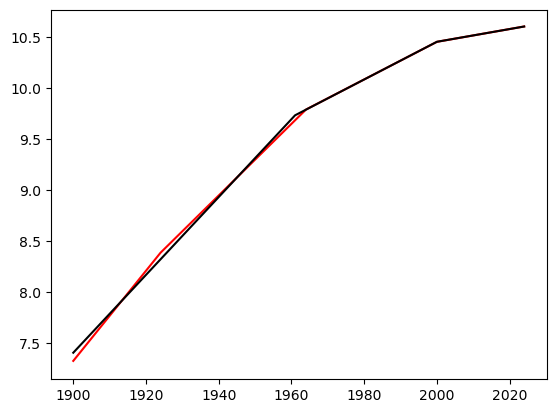

In [182]:
c = np.array(c_opt)
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x])
if np.isscalar(c):
    c = np.array([c])
for j in range(len(c)):
    xc = ((x > c[j]).astype(float))*(x-c[j])
    X = np.column_stack([X, xc])
md_c3 = sm.OLS(y, X).fit()
plt.plot(tme, y, color = 'None')
#plt.plot(tme, y, color = 'blue')
plt.plot(tme, md_c3.fittedvalues, color = 'red')
plt.plot(tme, md_c2.fittedvalues, color = 'black')
#plt.plot(tme, md.fittedvalues, color = 'black')
plt.show()